In [1]:
import numpy as np
import pandas as pd
import time
import scipy
import itertools
import seaborn as sns
import os

import sklearn.datasets
import matplotlib.pyplot as plt
import numpy.linalg as la

from sklearn.datasets import load_svmlight_file
from helpers import get_solution, run_diana_svrg, run_diana_saga, run_diana_lsvrg, read_logs, read_logs_qsvrg, run_diana_sgd
from logreg_functions import logreg_loss as single_point_loss

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'helpers'

In [2]:
def logreg_loss(ws, X, y, l1=0, l2=0):
    n = len(y)
    if 2 in y:
        y = 2 * y - 3
    return [np.mean(np.log(1 + np.exp(-X @ w * y))) + l2 / 2 * np.linalg.norm(w, ord=2) ** 2 + l1 * np.linalg.norm(w, ord=1) for w in ws]

### Get data for testing

In [4]:
data_path = '../datasets/'
dataset = 'mushrooms'
zero_based = {'mushrooms': False, 'a5a': False, 'a8a': False}
X, y = load_svmlight_file(data_path + dataset, zero_based=zero_based.get(dataset, 'auto'))
X = X.toarray()
n, d = X.shape
if 2 in y:
    y = 2 * y - 3
L = 0.25 * np.max(np.sum(np.square(X), axis=1))

### Define some experiment parameters and split data

##### If 0 returned, then it was successfully executed. To debug, use the code below with your own path to the code

In [5]:
n_workers = 20
t_epoch_of_n_workers = {}
big_regularization = True
reg_type = 'big' if big_regularization else 'small'
user_dir = os.path.expanduser('~/')
data_path = user_dir + 'distr_opt/data_logreg/'
code_path = user_dir + 'distr_opt/'
logs_path = user_dir + 'plots/diana/raw_data_{}/'.format(dataset)

os.system("bash -c 'python {0}generate_data.py --n_workers {1} -l{2} --dataset {3}'".format(code_path,
                                                                                            n_workers, 
                                                                                            ' -b' if big_regularization else '', 
                                                                                            dataset))
data_info = np.load(data_path + 'data_info.npy')
N, L = data_info[:2]
Ls = data_info[2:]
l2 = np.mean(Ls) / N if big_regularization else 0.1 * np.mean(Ls) / N

#### Solve the problem using SVRG or load the solution to memory, if precomputed

In [6]:
w_star, ws_svrg = get_solution(X, y, data_path, dataset, big_regularization, eta=1.5e-1 / L)
f_star = single_point_loss(w_star, X, y, l2=l2)

Computing the solution using SVRG


### Remove old results (if needed)

In [8]:
# !rm ../plots/diana/raw_data/*

rm: cannot remove '../plots/diana_vr/raw_data/*': No such file or directory


### Define Diana parameters and run it

##### Do not redefine n_workers without redestribituing the data

In [11]:
max_t = 40
n_epochs = 400
max_it = int(n_epochs * n // n_workers)
alphas = [0.005]
p_norms = [0]
batches = [1]
block_sizes = [n_workers ** 2]
ls = [n // 8]
lrs = [7] # lr=a is equivalent to using stepsize a / L

run_diana_svrg(n_workers, code_path, max_it, max_t, alphas, p_norms, batches, 
               block_sizes, ls, lrs, big_regularization, dataset)

#

## Process the results

In [12]:
for params in itertools.product(alphas, p_norms, batches, block_sizes, ls, lrs):
    alpha, p_norm, batch, block_size, l, lr = params
    ws_diana_svrg, loss_diana_svrg, its_diana_svrg, ts_diana_svrg = read_logs(
        p_norm, alpha, batch, block_size, big_regularization, lr, logs_path, method='svrg')

In [186]:
t_epoch_of_n_workers[n_workers] = n_epochs * n / ts_diana_svrg[-1]

In [148]:
for key in t_epoch_of_n_workers:
    t_epoch_of_n_workers[key] = n_epochs * n * t_epoch_of_n_workers[key]

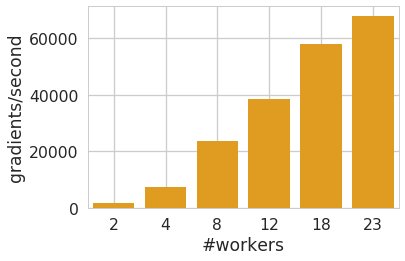

In [179]:
import seaborn as sns
df = pd.DataFrame.from_dict(t_epoch_of_n_workers, orient='index')
df.columns = ['gradients/second']
df.index.name = '#workers'
df.reset_index(level=0, inplace=True)
sns.set(style="whitegrid", context="talk", font_scale=1.2)
sns.barplot(x="#workers", y="gradients/second", data=df, color='orange')
plt.grid(True)
plt.tight_layout()
plt.savefig("../plots/diana/diana_svrg_mushrooms_scaling.pdf")
plt.show()

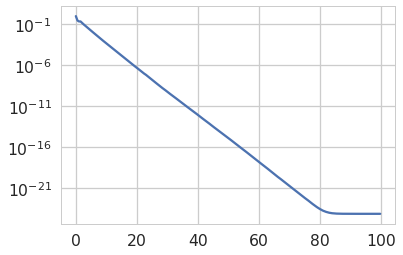

In [1192]:
plt.plot(ts_diana_svrg, np.linalg.norm(ws_diana_svrg - w_star, axis=1) ** 2 / np.linalg.norm(ws_diana_svrg[0] - w_star) ** 2)
plt.yscale('log')

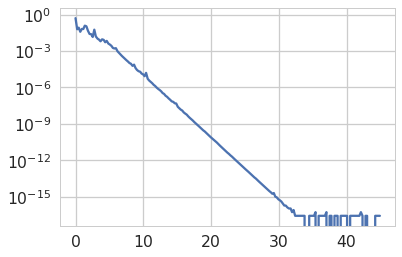

In [1202]:
plt.plot(ts_diana_svrg, loss_diana_svrg - single_point_loss(w_star, X, y, l2=l2))
# plt.plot(ts_diana_svrg, np.array(logreg_loss(ws_diana_svrg, X, y, l2=l2)) - f_star)
# plt.plot(np.linalg.norm(ws_diana_svrg - w_star, axis=1))
plt.yscale('log')
plt.show()

## SAGA

In [970]:
max_t = 60
max_it = int(1e9)
alphas = [0.01]
p_norms = [0]
batches = [1]
block_sizes = [n_workers ** 2]
lrs = [4] # lr=a is equivalent to using stepsize a / L

run_diana_saga(n_workers, code_path, max_it, max_t, alphas, p_norms, batches, block_sizes, ls, lrs, big_regularization, dataset)

##### For debugging use the line below

In [284]:
# !mpiexec -n 11 python /home/mishchk/distr_opt/diana_saga.py --max_it 10000000 --max_t 10 --alpha 0.1 --p_norm 2 --batch 1 --block_size 1 --lr 0.1

In [971]:
for params in itertools.product(alphas, p_norms, batches, block_sizes, lrs):
    alpha, p_norm, batch, block_size, lr = params
    ws_diana_saga, loss_diana_saga, its_diana_saga, ts_diana_saga = read_logs(
        p_norm, alpha, batch, block_size, big_regularization, lr, logs_path, method='saga')

In [834]:
w_star = np.mean(ws_diana_saga[-5:], axis=0)
f_star = single_point_loss(w_star, X, y, l2=l2)

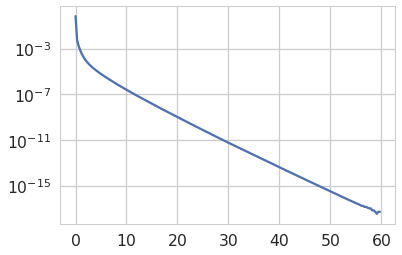

In [976]:
# plt.plot(ts_diana_svrg, loss_diana_svrg - logreg_loss([w_star], X, y, l2=l2))
plt.plot(ts_diana_saga, np.array(logreg_loss(ws_diana_saga, X, y, l2=l2)) - f_star)
plt.yscale('log')
plt.show()

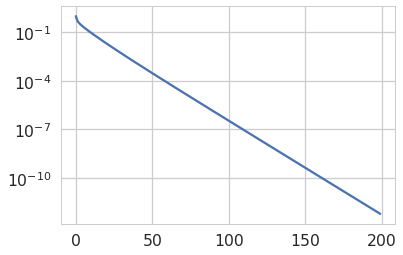

In [977]:
plt.plot(np.linalg.norm(ws_diana_svrg - w_star, axis=1) ** 2 / np.linalg.norm(ws_diana_svrg[0] - w_star) ** 2)
plt.yscale('log')

## LSVRG method

In [978]:
max_t = 60
max_it = int(1e9)
alphas = [0.01]
p_norms = [0]
batches = [1]
block_sizes = [n_workers ** 2]
lrs = [6] # lr=a is equivalent to using stepsize a / L

run_diana_lsvrg(n_workers, code_path, max_it, max_t, alphas, p_norms, batches, block_sizes, ls, lrs, big_regularization, dataset)

##### For debugging use the line below

In [475]:
# !mpiexec -n 11 python /home/mishchk/distr_opt/diana_st_met.py --max_it 10000000 --max_t 10 --alpha 0.1 --p_norm 2 --batch 1 --block_size 1 --lr 0.1

In [979]:
for params in itertools.product(alphas, p_norms, batches, block_sizes, lrs):
    alpha, p_norm, batch, block_size, lr = params
    ws_diana_lsvrg, loss_diana_lsvrg, its_diana_lsvrg, ts_diana_lsvrg = read_logs(
        p_norm, alpha, batch, block_size, big_regularization, lr, logs_path, method='lsvrg')

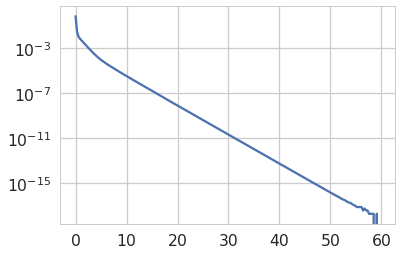

In [980]:
# plt.plot(ts_diana_svrg, loss_diana_svrg - logreg_loss([w_star], X, y, l2=l2))
plt.plot(ts_diana_lsvrg, np.array(logreg_loss(ws_diana_lsvrg, X, y, l2=l2)) - f_star)
plt.yscale('log')
plt.show()

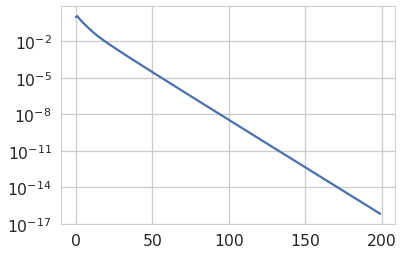

In [981]:
plt.plot(np.linalg.norm(ws_diana_lsvrg - w_star, axis=1) ** 2 / np.linalg.norm(ws_diana_lsvrg[0] - w_star) ** 2)
plt.yscale('log')

### SGD

In [21]:
max_t = 60
max_it = int(1e9)
alphas = [0.01]
p_norms = [0]
batches = [1]
block_sizes = [n_workers ** 2]
thetas = [5] # the stepsize is 2 / (L * theta + l2 * t)
momentums = [0.9]

run_diana_sgd(n_workers, code_path, max_it, max_t, alphas, p_norms, batches, block_sizes, thetas, momentums, big_regularization, dataset)

In [22]:
for params in itertools.product(alphas, p_norms, batches, block_sizes, momentums):
    alpha, p_norm, batch, block_size, momentum = params
    ws_diana_sgd, loss_diana_sgd, its_diana_sgd, ts_diana_sgd = read_logs(
        p_norm, alpha, batch, block_size, big_regularization, momentum, logs_path, method='sgd')

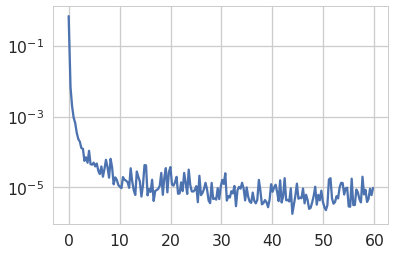

In [989]:
plt.plot(ts_diana_sgd, np.array(logreg_loss(ws_diana_sgd, X, y, l2=l2)) - f_star)
plt.yscale('log')
plt.show()

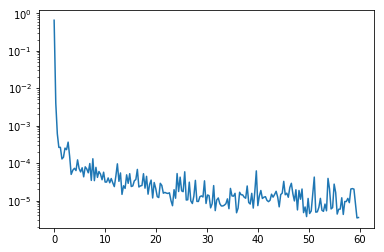

In [23]:
plt.plot(ts_diana_sgd, np.array(logreg_loss(ws_diana_sgd, X, y, l2=l2)) - f_star)
plt.yscale('log')
plt.show()

### QSVRG

In [992]:
max_t = 60
max_it = int(n * 60)
batches = [1]
block_sizes = [n_workers ** 2]
ls = [n // 8]
lrs = [3] # lr=a is equivalent to using stepsize a / L

run_qsvrg(n_workers, code_path, max_it, max_t, batches, block_sizes, ls, lrs, big_regularization, dataset)

In [993]:
for params in itertools.product(batches, block_sizes, ls, lrs):
    batch, block_size, l, lr = params
    ws_qsvrg, loss_qsvrg, its_qsvrg, ts_qsvrg = read_logs_qsvrg(batch, block_size, big_regularization, lr, logs_path)

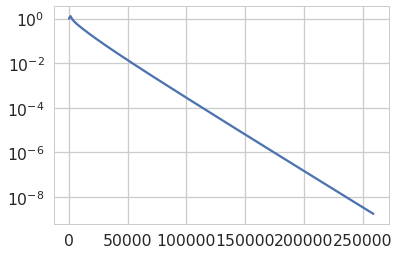

In [994]:
plt.plot(its_qsvrg, np.linalg.norm(ws_qsvrg - w_star, axis=1) ** 2 / np.linalg.norm(ws_qsvrg[0] - w_star) ** 2)
plt.yscale('log')

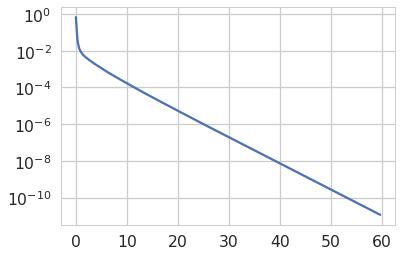

In [995]:
plt.plot(ts_qsvrg, np.array(logreg_loss(ws_qsvrg, X, y, l2=l2)) - f_star)
plt.yscale('log')

### ADAM

In [94]:
max_t = 30
max_it = int(1e9)
p_norms = [0]
batches = [1]
block_sizes = [40]
lrs = [4e-3]
beta1s = [0.9]
beta2s = [0.999]

run_adam(n_workers, code_path, max_it, max_t, block_sizes, lrs, beta1s, beta2s, big_regularization, dataset)

In [95]:
for params in itertools.product(block_sizes, beta1s, beta2s, lrs):
    block_size, beta1, beta2, lr = params
    ws_adam, loss_adam, its_adam, ts_adam = read_logs_adam(
        block_size, beta1, beta2, big_regularization, lr, logs_path)

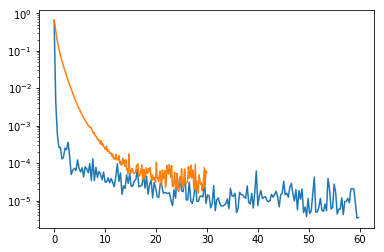

In [96]:
plt.plot(ts_diana_sgd, np.array(logreg_loss(ws_diana_sgd, X, y, l2=l2)) - f_star)
plt.plot(ts_adam, np.array(logreg_loss(ws_adam, X, y, l2=l2)) - f_star)
plt.yscale('log')
plt.show()

## Plot comparison

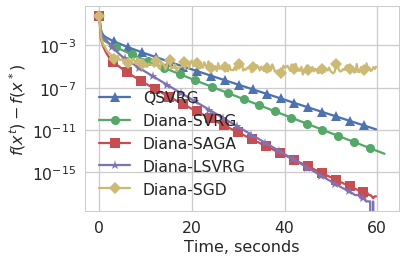

In [1004]:
sns.set(style="whitegrid", context="talk", font_scale=1.2)
plt.plot(ts_qsvrg, loss_qsvrg - f_star, label='QSVRG', marker='^', markevery=10)
plt.plot(ts_diana_svrg[:180], loss_diana_svrg[:180] - f_star, label='Diana-SVRG', marker='o', markevery=10)
plt.plot(ts_diana_saga, loss_diana_saga - f_star, label='Diana-SAGA', marker='s', markevery=10)
plt.plot(ts_diana_lsvrg, loss_diana_lsvrg - f_star, label='Diana-LSVRG', marker='*', markevery=10)
plt.plot(ts_diana_sgd, loss_diana_sgd - f_star, label='Diana-SGD', marker='D', markevery=10)
plt.xlabel('Time, seconds',fontsize=16)
plt.ylabel('$f(x^t) - f(x^*)$', fontsize=16)
plt.legend()
plt.yscale('log')
plt.tight_layout()
# plt.savefig('../plots/diana/func_{0}_{1}.pdf'.format(dataset, reg_type))

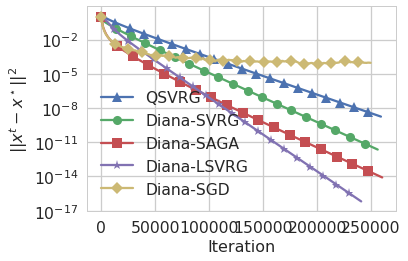

In [1012]:
plt.plot(its_qsvrg, la.norm(ws_qsvrg - w_star, axis=1) ** 2 / la.norm(ws_qsvrg[0] - w_star) ** 2,
         label='QSVRG', marker='^', markevery=10)
plt.plot(its_diana_svrg[:190], la.norm(ws_diana_svrg[:190] - w_star, axis=1) ** 2 / la.norm(ws_diana_svrg[0] - w_star) ** 2, 
         label='Diana-SVRG', marker='o', markevery=10)
plt.plot(its_diana_saga[:180], la.norm(ws_diana_saga[:180] - w_star, axis=1) ** 2 / la.norm(ws_diana_saga[0] - w_star) ** 2,
         label='Diana-SAGA', marker='s', markevery=10)
plt.plot(its_diana_lsvrg, la.norm(ws_diana_lsvrg - w_star, axis=1) ** 2 / la.norm(ws_diana_lsvrg[0] - w_star) ** 2,
         label='Diana-LSVRG', marker='*', markevery=10)
plt.plot(its_diana_sgd, la.norm(ws_diana_sgd - w_star, axis=1) ** 2 / la.norm(ws_diana_sgd[0] - w_star) ** 2,
         label='Diana-SGD', marker='D', markevery=10)
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('$||x^t - x^\star||^2$', fontsize=16)
plt.legend()
plt.yscale('log')
plt.tight_layout()
# plt.savefig('../plots/diana/dist_{0}_{1}.pdf'.format(dataset, reg_type))

##### for debugging:

In [250]:
# !mpiexec -n 8 python /home/mishchk/distr_opt/qsvrg.py --max_it 10000 --max_t 5 --batch 1 --block_size 1 --l 10000 --lr 1

In [ ]:
#!mpiexec -n 21 python /home/mishchk/distr_opt/diana_svrg.py --max_it 10000000 --max_t 5 --alpha 0.0001 --p_norm 2 --batch 1 --block_size 1 --lr 0.1